##   NYC Airbnb data - Modeling the listing price

    By Muluemebet Ayalew
       March,2020

In [2]:
#Important libraries

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import skew     # to calculate the skewness of numerical columns
import statsmodels.api as sm     # to graph QQplot
import re                        # to match  regular expression 
from sklearn import preprocessing  # to use label encoding
from sklearn.model_selection import train_test_split # to split the data into training and test set
from sklearn.linear_model import LinearRegression    # to make regression model
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error # performance measures
from catboost import Pool, CatBoostRegressor
%matplotlib inline


In [ ]:
# to select parameters using cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
from catboost import Pool, CatBoostRegressor

## 1) Get the original and cleaned data 

In [8]:
#original data downloaded on end of January
ny= pd.read_csv("listings.csv", parse_dates=["last_review"]) # read the last_review column as datetime

In [8]:
ny.columns  # list of column names

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

## Read the cleaned data 
This data has non zero price, none NaN for reviews_per_month. New features such as is_hotel, distance from some point of interest.

In [9]:
# read the cleaned data for further analysis
new_ny= pd.read_csv("NYC_cleaned.csv", parse_dates=["last_review"])

In [10]:
new_ny.shape # now the shape of the dataframe is changed


(50583, 22)

In [11]:
new_ny.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'location',
       'dist_nearest_SubwayStation', 'dist_nearest_SubwayEntrance',
       'dist_from_TimeSqr', 'dist_from_PennStation'],
      dtype='object')

## 2) Dealing with Outliers 
 
 The data with price beyond three standard deviation from the mean price are removed from the analysis.

In [12]:
# removing outliers  beyond three standard deviation from the mean

In [10]:
mean_p=new_ny["price"].mean()
std_p=new_ny["price"].std()
three_sigma= mean_p + (3*std_p)

In [11]:
three_sigma # upper limit for price

1202.6215388898568

In [76]:
# detaframe with prices below (mean +3 *standard_deviation)
clean_ny= new_ny[new_ny["price"]<three_sigma]

In [77]:
# the new dataframe after prices above three standard deviations from the mean removed 
clean_ny.shape

(50352, 22)

## 3) Feature Encoding 

The data has catagorical variables. we need to encode those variables.  For the variables neighbourhood_group and room_type, dummy variables are created using pandas method get_dummies(). However, the variable neighbourhood contains 223 unique values and creating dummy makes the model complex and computationaly expensive. A better way to hand this is by using target encoding. The median price for each group is computed and used as a predictor variable. But this has to be done after spliting the data into training and test data. 

#### Creat dummies for nighbourhood_group and room_type

In [84]:
# get catagorical columns
clean_ny.select_dtypes("object").columns

Index(['name', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'location'],
      dtype='object')

Right now, we are interested with neighbourhood_group and room_type. We will deal with neighbourhood later.  

In [85]:
#convert neighbourhood_group and room_type into dummy variables
neighbourg_room= pd.get_dummies(clean_ny[["neighbourhood_group", "room_type"]],drop_first=True)

In [86]:
neighbourg_room.head(2)

,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0


In [87]:
# merge the dataframes with dummy variables to the original data
merged= pd.concat([clean_ny,neighbourg_room], axis=1)


In [88]:
merged.shape # the shape after creating dummy variebles

(50352, 29)

## 4) Split the data into training and test set 
Before performing target incoding we need to split the data into training and validating. Variables such as distance form Time Square and distance from Penn Station are highly correlated. Only one variable(distance from Penn Station) is included in the analysis. Distance from subwy entrance and distance from subway station are also correlated. Only distance from subwy entrance is included in the model. 
The whole data set including the response variable is splited into training and test data. To make the follow up modelling easier, the training and test data contains all the variables including variables that will not be included in the model. Base on the need and type of encoding needed for specific algorithm, we will modify or choose predictor variables from the whole list. 

In [138]:
X=merged   # the whole data set
y=merged["price"]  # target,response variable

# split training(70%) and test data(30%)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3, random_state=42)

In [139]:
X_test.shape

(15106, 29)

In [140]:
X_train.shape

(35246, 29)

### Target encoding 
Since nighbourhood has large categories, target encoding is used. Target encoding is performed for both training and test data separately. 

**Encoding for training data**

In [141]:
# # group the neighbourhood by median price
train=X_train.groupby("neighbourhood")["price"].agg("median").reset_index()

# encode the neighbourhood by its median price 
train_encoder= {train.neighbourhood[i]: train.price[i] for i in range(train.shape[0])}

# map the encoder
X_train["neighb_encoded"] = X_train["neighbourhood"].map(train_encoder)

# look at the group median price
train.columns=['neighbourhood', 'median price']
train.head(2) 


C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,neighbourhood,median price
0,Allerton,65.0
1,Arden Heights,75.0


**Encoding for test data**

In [155]:
# group the neighbourhood by median price
test=X_test.groupby("neighbourhood")["price"].agg("median").reset_index()

# encode the neighbourhood by its median price 
test_encoder= {test.neighbourhood[i]: test.price[i] for i in range(test.shape[0])}

# map the encoder
X_test["neighb_encoded"] = X_test["neighbourhood"].map(test_encoder) 


C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  




## 5) Prediction 

## 5.1)  Linear model with two senarios

   ### a) Without transformation of response variable

In [301]:
# all the selected features 
col=['neighb_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', \
     'calculated_host_listings_count', 'availability_365', 'is_hotel', \
     'dist_nearest_SubwayEntrance','dist_from_PennStation', 'neighbourhood_group_Brooklyn', \
     'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', \
     'neighbourhood_group_Staten Island', 'room_type_Hotel room', 'room_type_Private room', \
     'room_type_Shared room']
print(len(col)) # number of predictor variables

16


In [226]:
# fit with Linear regrassion with the selected predictor variables
Xl_train= X_train[col]
Xl_test= X_test[col]
linear=LinearRegression().fit(Xl_train,y_train)

In [227]:
linear.intercept_ # the intercept of the model

104.77097679367517

In [228]:
linear.coef_ # the coeficients of predictor variables

array([ 7.40943597e-01, -3.03421588e-01, -1.26654926e-01, -7.80395069e-01,
       -1.90318261e-01,  1.03350296e-01,  8.90926892e+01,  3.30930967e-01,
       -1.48575722e+00,  1.56305308e-01,  2.54372795e+00,  1.98510337e+00,
       -2.15383130e+00, -9.97734541e+01, -8.97841223e+01, -1.12923879e+02])

In [230]:
# Predict for training data
trainl_pred=linear.predict(Xl_train)

#predict for test data
testl_pred= linear.predict(Xl_test)

### See the performance of the model for training and test data

In [208]:
def model_output(y_true, y_pred):
    _=plt.scatter(y_true, y_pred) # see the predicted and actual values
    _=plt.xlabel("Actual")
    _=plt.ylabel("Predicted")
    
    #performance measure
    print("r2 = ",r2_score(y_true,y_pred)) # r2
    print("mean_absolute_error = ", mean_absolute_error(y_true,y_pred))
    print("mean_squared_error = ", mean_squared_error(y_true, y_pred))    
    

 Performance of training data
r2 =  0.3266127987865659
mean_absolute_error =  55.14786732246461
mean_squared_error =  9671.908373854429
 Performance of test data 
r2 =  0.32649306462170424
mean_absolute_error =  56.10848811973172
mean_squared_error =  9970.002325807229


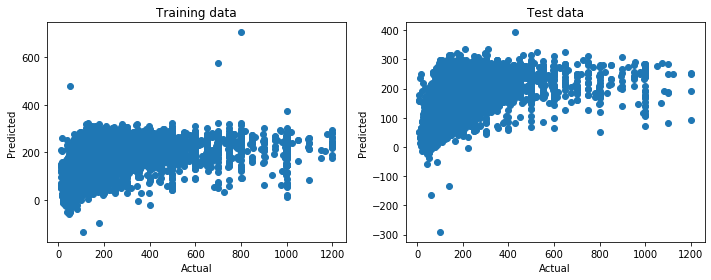

In [231]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,trainl_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test,testl_pred)
plt.title("Test data")
plt.tight_layout()




### b) With log transformation of outcome variable(price)¶
The model performed better after logtransformation of target variable(price).

In [232]:
yl_train_log=np.log(y_train) # log transformation of price for training data
yl_test_log= np.log(y_test) # log transformtion of price for test data

In [233]:
linear_log= LinearRegression().fit(Xl_train,yl_train_log)
trainl_logpred= linear_log.predict(Xl_train)
testl_logpred=linear_log.predict(Xl_test)

 Performance of training data
r2 =  0.5622792943910813
mean_absolute_error =  0.3327839020834781
mean_squared_error =  0.19713803317172812
 Performance of test data 
r2 =  0.5622516523876205
mean_absolute_error =  0.33292308199651416
mean_squared_error =  0.19955662864828258


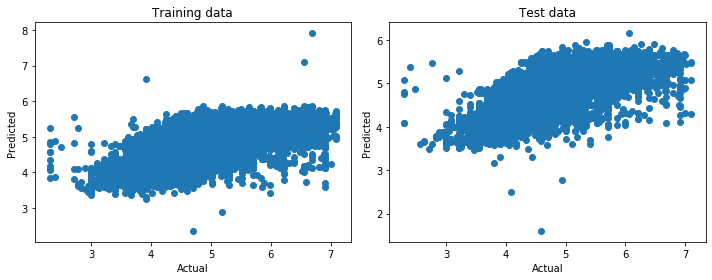

In [234]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")
model_output(yl_train_log, trainl_logpred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m")
model_output(yl_test_log,testl_logpred)
plt.title("Test data")
plt.tight_layout()

## 5.2)  Decision Tree model

The encoding done for linear model may not be effective for the tree based algorithem. The categorical variables should be encoded differently here.

**Encode room_type:** Now the room type are assumed ordinal based on their price. The room type in ascending order of expence are shared room, private room, entire home/appartment and hotel room.

In [165]:
merged.groupby("room_type")["price"].mean().sort_values()

room_type
Shared room         64.800000
Private room        83.673536
Entire home/apt    194.101667
Hotel room         240.122892
Name: price, dtype: float64

In [235]:
# maper to encode room_type 
room_maper={k: v+1 for v, k in enumerate(['Shared room','Private room', 'Entire home/apt','Hotel room'])}
print(room_maper)

{'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3, 'Hotel room': 4}


In [241]:
# encode room types
X_train["room_encoded"]= X_train["room_type"].map(room_maper)
X_test["room_encoded"]=X_test["room_type"].map(room_maper)

C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Encode neighbourhood_group:** The sum of the square of the mean latitude and longitude is used to encode neighbourhood groups. 

In [236]:
#neighb_encoder = preprocessing.LabelEncoder() #encode alphabetically 
# neighbr= neighb_encoder.fit_transform(merged["neighbourhood_group"]) 

In [290]:
neigh_g= merged.groupby("neighbourhood_group")["latitude","longitude"].agg("mean").reset_index()
neigh_g["slope"]= neigh_g.latitude**2 +neigh_g.longitude**2 # add slop column
neigh_g

,neighbourhood_group,latitude,longitude,slope
0,Bronx,40.848570,-73.883476,7127.373670
1,Brooklyn,40.684420,-73.950757,7123.936515
2,Manhattan,40.765378,-73.974425,7134.031681
3,Queens,40.730763,-73.869981,7115.769146
4,Staten Island,40.611745,-74.104278,7140.757917


In [291]:
# create a dictionary to encode neighbourhood group by slope
ngroup_mapper= {k:v for k,v in zip(neigh_g["neighbourhood_group"],neigh_g["slope"])}

In [292]:
# encode neighbourhood group for both training and test data
X_train["neigh_group_encoded"]= merged["neighbourhood_group"].map(ngroup_mapper)
X_test["neigh_group_encoded"]= merged["neighbourhood_group"].map(ngroup_mapper)

C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\tayeh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [297]:
#note that the neighbourhood is note included
col_t= ['neighb_encoded', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 
      'calculated_host_listings_count','availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance',\
        'dist_from_PennStation','neigh_group_encoded',
     'room_encoded']

In [298]:
# extract the predictor variables for training and test data set
Xd_train=X_train[col_t]
Xd_test= X_test[col_t]

In [302]:
# to select parameters using cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [303]:
dt= DecisionTreeRegressor(criterion='mse',max_depth=10, min_impurity_decrease=2)
dt.fit(Xd_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=2,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [304]:
dt_train_pred=dt.predict(Xd_train)
dt_test_pred=dt.predict(Xd_test)

In [ ]:
r2 =  0.4957410528352886
mean_absolute_error =  48.301462209139224
mean_squared_error =  7242.70720453974
 Performance of test data 
r2 =  0.3363708750577923
mean_absolute_error =  52.88232812168564
mean_squared_error =  9823.779936922152

 Performance of training data
r2 =  0.49819703721951036
mean_absolute_error =  48.20820824281603
mean_squared_error =  7207.4317257527855
 Performance of test data 
r2 =  0.168319028053164
mean_absolute_error =  56.82133644826614
mean_squared_error =  12311.471180296301


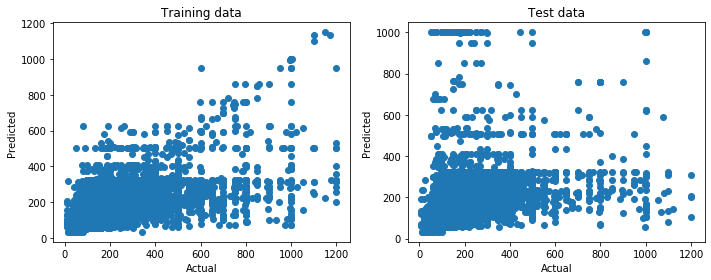

In [305]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,dt_train_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test,dt_test_pred)
plt.title("Test data")
plt.tight_layout()


## Random forest 

In [314]:
# Create RandomForestClassifier object
rf = RandomForestRegressor(n_estimators=7, max_depth=4)
rf.fit(Xd_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [315]:
rf_train_pred=dt.predict(Xd_train)
rf_test_pred=dt.predict(Xd_test)

 Performance of training data
r2 =  0.49819703721951036
mean_absolute_error =  48.20820824281603
mean_squared_error =  7207.4317257527855
 Performance of test data 
r2 =  0.168319028053164
mean_absolute_error =  56.82133644826614
mean_squared_error =  12311.471180296301


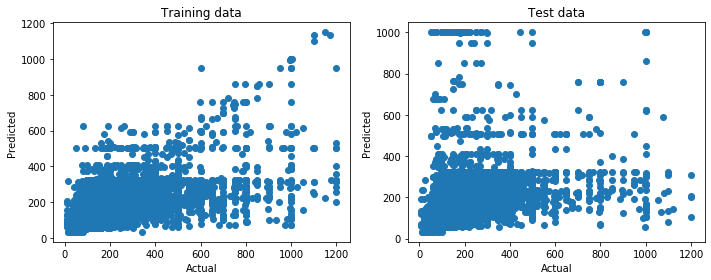

In [316]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")# print in bold
model_output(y_train,rf_train_pred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m") # print in bold
model_output(y_test, rf_test_pred)
plt.title("Test data")
plt.tight_layout()

In [317]:
grid_dt= GridSearchCV(estimator=dt, param_grid=[{"max_depth": np.arange(2,11)}],scoring='', cv= 4)
grid_dt.fit(Xd_train,y_train)

ValueError: '' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [311]:
y_train_dtpred=dt.predict(X_train)
y_test_dtpred= dt.predict(X_test)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
print("\033[1m Performance of training data\033[0m")
model_output(y_train, y_train_dtpred)
plt.title("Training data")

plt.subplot(1,2,2)
print("\033[1m Performance of test data \033[0m")
model_output(y_test,y_test_dtpred)
plt.title("Test data")
plt.tight_layout()

In [305]:
# make the tree graph
from sklearn.tree import export_graphviz

In [306]:
export_graphviz(dt, out_file="decisionTree.dot")

# Using catboost

In [16]:
col_cat=['neighbourhood_group',
       'neighbourhood', 'room_type',
       'minimum_nights', 'number_of_reviews', 
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'is_hotel', 'dist_nearest_SubwayEntrance', 'dist_from_PennStation']

In [29]:
xcat= clean_ny[col_cat]
ycat=clean_ny["price"]
X_train, X_test, y_train, y_test = train_test_split(xcat, ycat,test_size = 0.3, random_state=42)


In [62]:

# initialize Pool
train_pool = Pool(X_train, 
                  np.log(y_train), 
                  cat_features=[0,1,2])
test_pool = Pool(X_test, 
                  cat_features=[0,1,2])

# specify the training parameters 
model = CatBoostRegressor(iterations=10, 
                          depth=4, 
                          learning_rate=0.8, 
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
train_preds = model.predict(train_pool)
test_preds = model.predict(test_pool)
print(train_preds)

0:	learn: 0.4777798	total: 30.4ms	remaining: 274ms
1:	learn: 0.4567920	total: 45.4ms	remaining: 181ms
2:	learn: 0.4463222	total: 58.9ms	remaining: 137ms
3:	learn: 0.4423924	total: 72.6ms	remaining: 109ms
4:	learn: 0.4383770	total: 81.2ms	remaining: 81.2ms
5:	learn: 0.4338939	total: 95.3ms	remaining: 63.5ms
6:	learn: 0.4313172	total: 104ms	remaining: 44.7ms
7:	learn: 0.4299194	total: 114ms	remaining: 28.4ms
8:	learn: 0.4288722	total: 123ms	remaining: 13.7ms
9:	learn: 0.4276378	total: 133ms	remaining: 0us
[4.79816158 5.27549121 4.51012761 ... 4.05366261 5.53960632 4.77960934]


In [75]:
model.feature_importances_

array([ 3.47102195,  0.93042434, 61.77833566,  3.19169459,  0.60511994,
        1.53709622,  1.06633383,  3.97514171,  0.94111382,  0.        ,
       22.50371793])

In [74]:
np.sqrt(0.18576295913686858)

0.4310022727745975

r2 =  0.5925095099042204
mean_absolute_error =  0.31956914258581215
mean_squared_error =  0.18576295913686858


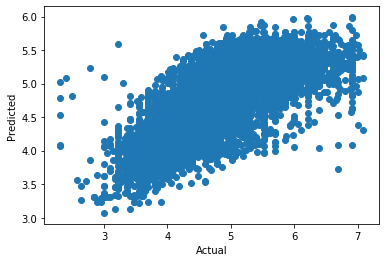

In [64]:
 model_output(np.log(y_test), test_preds)